### Dogs Image Research

Esse notebook foi feito para facilitar o treinamento e para gerar um report final de como foi treinado o modelo. Com ele caso seu dataset seja dividido por pastas facilita o treino.

by: Crystal Silva Campos <https://github.com/campos537>

### Step  1
Primeiro passo feito foi importar as bibliotecas utilizadas

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
# Plot library
import matplotlib.pyplot as plt
# Fast array processing library
import numpy as np
# Deep Learning framework
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
# Library to find the best learning rate
from torch_lr_finder import LRFinder
from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy
import cv2

### Step  2
Nesse passo separamos o dataset de treino do de teste, adicionando no transforms.Compose as augmentacoes que queremos para melhorar a generalização do nosso modelo

In [2]:
def load_split_train_test(train_data, test_data, input_size, batch_size = 64):
#   Divide and transform the train and validation data doing augmentation if needed
    train_transforms = transforms.Compose([
                                        transforms.Resize(input_size),
                                        ImageNetPolicy(),
                                        transforms.ToTensor(),
])

    test_transforms = transforms.Compose([transforms.Resize(input_size),
                                        transforms.ToTensor(),
                                      ])
#   Load the data depending on the path choosen  
    train_data = datasets.ImageFolder(train_data, transform=train_transforms)
    test_data = datasets.ImageFolder(test_data, transform=test_transforms)
    
    trainloader = torch.utils.data.DataLoader(train_data,shuffle=True, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,shuffle=True, batch_size=batch_size)
    return trainloader, testloader


## Step 3

Escolha os parametros de input que vao ser usados no dataset, tais como o input size e o tamanho do batch (Quanto maior mais memoria de video sera utilizada para o treinamento)

In [3]:
train_data = 'test_cleaned/'
test_data = "test_cleaned"
input_size = [224,224]
batch_size = 256

trainloader, testloader = load_split_train_test(train_data,test_data, input_size, batch_size)
print(trainloader.dataset.classes)


['Afghan_hound', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Bedlington_terrier', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'EntleBucher', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Pomeranian', 'Saint_Bernard', 'Saluki', 'Scotch_terrier', 'Sealyham_terrier', 'Shetland_sheepdog', 'Shih', 'Siberian_husky', 'Staffordshire_bullterrier', 'Sussex_spaniel', 'Tibetan_mastiff', 'Tibetan_terrier', '

## Step 4

Escolha a arquitetura do modelo e cheque se o CUDA esta disponivel para ser utilizado. Caso queira utilizar uma arquitetura e um modelo pretreinado pode checar o link: https://pytorch.org/docs/stable/torchvision/models.html

In [4]:
# Checks if CUDA is available and use cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
# Choose the model and show a summary
model = models.resnet50(pretrained=True)

True


## Step 5

Adicione o modelo no device (CPU ou GPU) e escolha o erro a ser utilizado e Funcao Optimizadora. Alem de poder utilizar o lr_finder para escolher um bom learning rate de inicio

In [5]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                  nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(512, len(trainloader.dataset.classes)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1.67E-01, momentum=0.9)
# Assign to the device
model.to(device)

# Use learning rate finder to help choose the best one 
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Step 6
Escolha a quantidade de epocas que o modelo ira treinar, o nome do modelo e inicie o treino

In [7]:
epochs = 300
import math
count_step = 0

steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
best_metrics = [-999.0, 999.0]
model_name = "dog_breed_resnet50"

t1 = cv2.TickMeter()
t1.start()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
#       Save every epoch
        if not os.path.exists('models/'+model_name+'/'):
            os.mkdir('models/'+model_name+'/')
        model_full_name = 'models/'+model_name+'/epoch_'+str(epoch)+'_inputsize_'+str(input_size[0])+'_'+str(input_size[1])+'_batchsize_'+str(batch_size)+'_name_'+model_name+'_.pt'
        torch.save(model, model_full_name) # official recommended
    
    test_loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()

            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    val_loss_fix = round(test_loss/len(testloader),3)
    val_acc_fix = round(accuracy/len(testloader),3)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/print_every:.3f}.. "
          f"Validation loss: {val_loss_fix}.. "
          f"Validation accuracy: {val_acc_fix}")
    
    running_loss = 0
    count_step += 1
    model.train()
t1.stop()
print("TRAINING TIME: ", t1.getTimeSec())


Epoch 1/300.. Train loss: 3.150.. Validation loss: 4.021.. Validation accuracy: 0.122
Epoch 2/300.. Train loss: 2.631.. Validation loss: 2.638.. Validation accuracy: 0.306
Epoch 3/300.. Train loss: 1.891.. Validation loss: 1.622.. Validation accuracy: 0.585
Epoch 4/300.. Train loss: 1.441.. Validation loss: 0.962.. Validation accuracy: 0.694
Epoch 5/300.. Train loss: 1.183.. Validation loss: 0.712.. Validation accuracy: 0.78
Epoch 6/300.. Train loss: 1.125.. Validation loss: 0.589.. Validation accuracy: 0.816
Epoch 7/300.. Train loss: 1.035.. Validation loss: 0.497.. Validation accuracy: 0.847
Epoch 8/300.. Train loss: 0.933.. Validation loss: 0.435.. Validation accuracy: 0.852
Epoch 9/300.. Train loss: 0.931.. Validation loss: 0.443.. Validation accuracy: 0.857
Epoch 10/300.. Train loss: 0.982.. Validation loss: 0.38.. Validation accuracy: 0.88
Epoch 11/300.. Train loss: 0.979.. Validation loss: 0.362.. Validation accuracy: 0.884
Epoch 12/300.. Train loss: 0.904.. Validation loss: 0.2

KeyboardInterrupt: 

## Step 7
Ao final do treino plota a loss de treino e a de validacao para comparar e analisar como foi o treinamento.

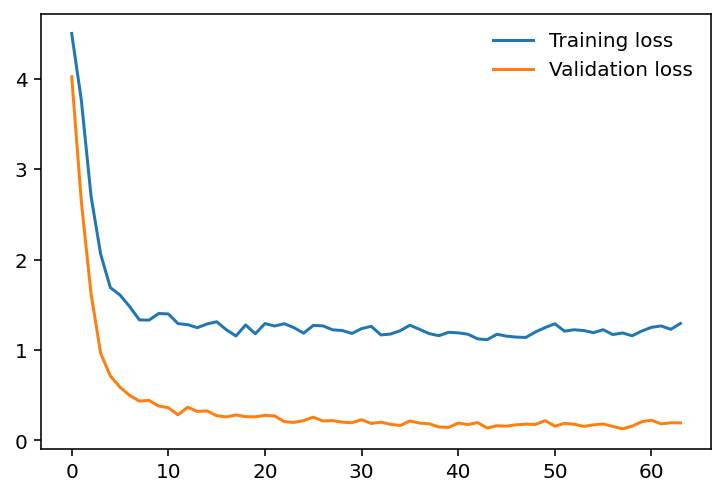

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()